In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
np.random.seed(123)
tf.random.set_seed(123)

In [4]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2022-01-10 04:07:35--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2022-01-10 04:07:35 (15.2 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [5]:
df = pd.read_csv('airline_passengers.csv', index_col = 'Month', parse_dates = True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [6]:
df['LogPassengers'] = np.log(df['Passengers'])

In [7]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [9]:
# Boolean index

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [10]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [17]:
# Make supervised dataset

series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10 # number of lags
X = [] # inputs
Y = [] # targets
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10) Y.shape (133,)


In [18]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

### Basic ANN

In [19]:
# Create input layer with dimensionality T
i = Input(shape = (T,))

# Create 1st hidden layer size of 32 with relu
x = Dense(32, activation = 'relu')(i) 

# Output layer Dense of output size 1. Because the initial model is a 1 step predictor
x = Dense(1)(x) 

# Instantiate model object passing the input and output
model = Model(i, x)

In [20]:
# Compiling the model object

model.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = 'mae')

In [21]:
# Call fit function

r = model.fit(Xtrain, Ytrain, epochs = 100,
              validation_data = (Xtest, Ytest))

Epoch 1/100
4/4 [==============================] - 1s 106ms/step - loss: 0.0119 - mae: 0.0857 - val_loss: 0.0099 - val_mae: 0.0877
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0107 - mae: 0.0834 - val_loss: 0.0093 - val_mae: 0.0852
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0099 - mae: 0.0817 - val_loss: 0.0089 - val_mae: 0.0828
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0094 - mae: 0.0804 - val_loss: 0.0086 - val_mae: 0.0815
Epoch 5/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0088 - mae: 0.0781 - val_loss: 0.0083 - val_mae: 0.0803
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0082 - mae: 0.0756 - val_loss: 0.0078 - val_mae: 0.0786
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0077 - mae: 0.0729 - val_loss: 0.0075 - val_mae: 0.0768
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0073 - mae: 0.0

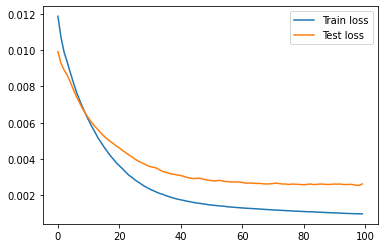

In [22]:
# Plot train and validation loss

plt.plot(r.history['loss'], label = 'Train loss')
plt.plot(r.history['val_loss'], label = 'Test loss')
plt.legend();

In [23]:
# First T+1 values are not predictable

train_idx[:T+1] = False 

In [24]:
# Compute model predictions

Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

In [25]:
# Store diff predictions

df.loc[train_idx, 'Diff ANN Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff ANN Test Prediction'] = Ptest

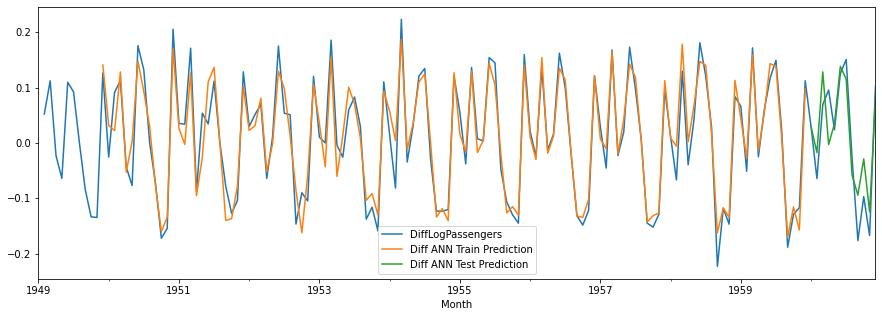

In [27]:
cols = ['DiffLogPassengers', 'Diff ANN Train Prediction', 'Diff ANN Test Prediction']
df[cols].plot(figsize = (15, 5));

In [28]:
# Need to compute un-differenced predictions

df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [29]:
# Last known train value

last_train = train.iloc[-1]['LogPassengers']

### 1-step

In [31]:
# 1-step forecast

df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

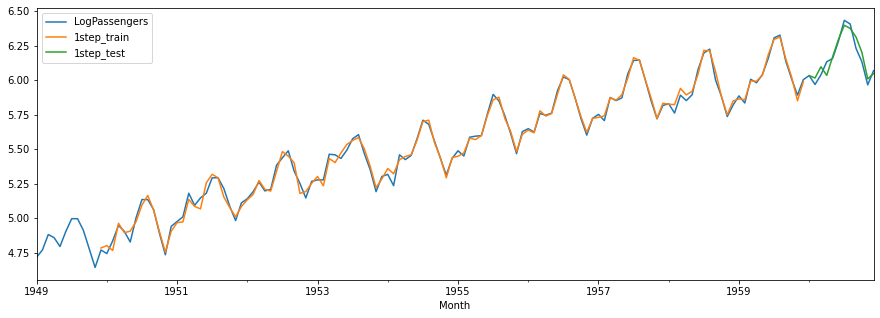

In [32]:
# Plot 1-step forecast

df[['LogPassengers', '1step_train', '1step_test']].plot(figsize = (15, 5));

### Multi-step

In [33]:
# Multi-step forecast 

multistep_predictions = []

# First test input

last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  # last_x array reshaped because sklearn only accepts 2D input
  p = model(last_x.reshape(1, -1))[0]

  # Update predictions list
  multistep_predictions.append(p)

  # Make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [34]:
# Save multi-step forecast to the dataframe

df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

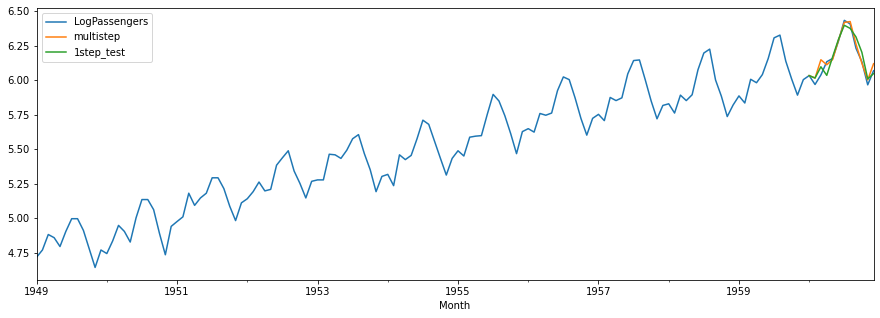

In [36]:
# Plot 1-step and multistep

df[['LogPassengers', 'multistep', '1step_test']].plot(figsize = (15, 5));

### Multi-output

In [47]:
# Make multi-output supervised dataset

Tx = T      # number of timesteps in the input
Ty = Ntest  # number of timesteps in the output
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10) Y.shape (122, 12)


In [48]:
# Split into train and test

Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [49]:
# Basic ANN

# Create input layer with dimensionality T
i = Input(shape = (Tx,))

# Create 1st hidden layer size of 32 with relu
x = Dense(32, activation = 'relu')(i) 

# Output layer Dense of output size 1. Because the initial model is a 1 step predictor
x = Dense(Ty)(x) 

# Instantiate model object passing the input and output
model = Model(i, x)

In [50]:
# Compiling the model object

model.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = 'mae')

In [51]:
# Call fit function

r = model.fit(Xtrain_m, Ytrain_m, epochs = 100,
              validation_data = (Xtest_m, Ytest_m))

Epoch 1/100
4/4 [==============================] - 0s 44ms/step - loss: 0.0153 - mae: 0.0979 - val_loss: 0.0103 - val_mae: 0.0788
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0140 - mae: 0.0939 - val_loss: 0.0092 - val_mae: 0.0761
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0129 - mae: 0.0907 - val_loss: 0.0083 - val_mae: 0.0737
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0121 - mae: 0.0879 - val_loss: 0.0076 - val_mae: 0.0711
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0113 - mae: 0.0854 - val_loss: 0.0070 - val_mae: 0.0685
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0107 - mae: 0.0833 - val_loss: 0.0065 - val_mae: 0.0658
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0102 - mae: 0.0814 - val_loss: 0.0062 - val_mae: 0.0636
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0097 - mae: 0.0795 

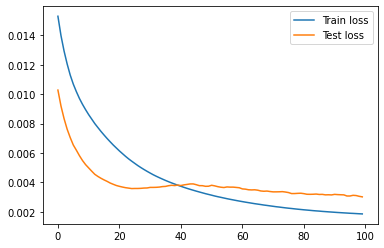

In [52]:
# Plot train and validation loss

plt.plot(r.history['loss'], label = 'Train loss')
plt.plot(r.history['val_loss'], label = 'Test loss')
plt.legend();

In [53]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

In [54]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [55]:
Ptrain = Ptrain[:, 0]
Ptest = Ptest[0]

In [56]:
# Save output to dataframe

df.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)

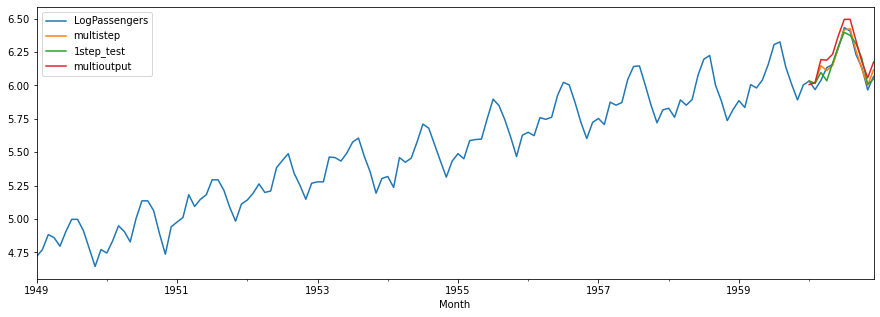

In [57]:
df[['LogPassengers', 'multistep', '1step_test', 'multioutput']].plot(figsize = (15, 5));

In [58]:
# Use different metric

# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']

mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multistep'])
print('Multi-step MAPE:', mape1)

mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multioutput'])
print('Multi-output MAPE:', mape2)

Multi-step MAPE: 0.00480787523281091
Multi-output MAPE: 0.012950723988712632
